# Part 1: Combine Baby Name Data

In [1]:
# cd homework5\babynamesbystate\babynamesbystate
# cat *.txt > combined_babynames.txt

# Part 2: Baby Name Class in Python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class BabyNames: 
    def __init__(self, path): 
        '''function creating dataframe'''
        try:
            # load data
            self.df = pd.read_csv(path, delimiter=',', encoding="UTF-8", header=None, on_bad_lines='skip')
            # set column names
            self.df.columns = ['State', 'Gender', 'Year', 'Name', 'Occurrences']
        
        # error handling
        except ValueError:
            print("Error: Column mismatch or incorrect format")
        except FileNotFoundError:
            print("Error: File not found. Please check the file path.")
        except Exception as e:
            print(f"Error: {e}")

    def count(self, state=None, year=None):
        '''function counting name according to state and year'''
        # filter by state and year if specified, else include all
        filtered_df = self.df
        if state is not None:
            filtered_df = filtered_df[filtered_df['State'] == state]
        if year is not None:
            filtered_df = filtered_df[filtered_df['Year'] == year]

        # return total occurrences
        total_births = filtered_df['Occurrences'].sum()
        return total_births

    def top_10_baby_names(self, state=None, year=None):
        '''function returning top 10 baby names according to state and year'''
        # filter by state and year if specified, else include all
        filtered_df = self.df
        if state is not None:
            filtered_df = filtered_df[filtered_df['State'] == state]
        if year is not None:
            filtered_df = filtered_df[filtered_df['Year'] == year]

        # get top 10 names for each gender
        top_male_names = (
            filtered_df[filtered_df['Gender'] == 'M']
            .groupby(['Name'])['Occurrences'].sum()
            .sort_values(ascending=False)
            .head(10)
        )
        top_female_names = (
            filtered_df[filtered_df['Gender'] == 'F']
            .groupby(['Name'])['Occurrences'].sum()
            .sort_values(ascending=False)
            .head(10)
        )

        # convert names to lists
        male_names_list = top_male_names.index.tolist()
        female_names_list = top_female_names.index.tolist()

        # error handling: length of name lists less than 10
        if len(male_names_list) < 10 or len(female_names_list) < 10:
            raise ValueError("Error: Unique names found less than 10.")
        
        # create a DataFrame to display the results
        top_10_df = pd.DataFrame({
            'Rank': range(1, 11),
            'Male': male_names_list,
            'Female': female_names_list
        })
    
        return top_10_df

    def name_popularity_plot(self, name=None, yrange=None, state=None, sex=None):
        '''function plotting popularity of a name according to year, state, and sex'''
        # error handling: missing input
        if name is None or yrange is None or state is None or sex is None:
            raise ValueError("Error: Missing input. Please specify name, yrange, state, and sex.")

        # error handling: yrange format incorrect
        if not isinstance(yrange, (list, tuple)) or len(yrange) != 2:
            raise ValueError("Error: Invalid yrange. Please provide a range of year (start, end).")
        
        # filter data by the specified state, gender, year range, and name
        filtered_df = self.df[
            (self.df['State'] == state) & 
            (self.df['Gender'] == sex) & 
            (self.df['Year'] >= yrange[0]) & 
            (self.df['Year'] <= yrange[1]) & 
            (self.df['Name'] == name)
        ]

        # sum occurrences of the specified name by year
        name_yearly_occurrences = filtered_df.groupby('Year')['Occurrences'].sum()

        # calculate total births (all baby names' occurrences) by year for the specified state and gender
        total_births_by_year = (
            self.df[
                (self.df['State'] == state) & 
                (self.df['Gender'] == sex) & 
                (self.df['Year'] >= yrange[0]) & 
                (self.df['Year'] <= yrange[1])
            ]
            .groupby('Year')['Occurrences']
            .sum()
        )

        # calculate the popularity based on the proportional use of the name within the state and year
        popularity_ratio = (name_yearly_occurrences / total_births_by_year) * 100

        # plot the popularity trend over the specified range of years
        plt.figure(figsize=(10, 6))
        plt.plot(popularity_ratio.index, popularity_ratio.values, marker='o', color='b', label=name)
        plt.title(f"Popularity of '{name}' in {state} ({sex}) from {yrange[0]} to {yrange[1]}")
        plt.xlabel("Year")
        plt.ylabel("Popularity (%)")
        plt.legend()
        plt.grid(True)
        plt.show()
            
    def change_in_popularity(self, from_year=2014, to_year=2015, top=10):
        '''function plotting popularity change for name in specified year'''
        # filter data for each year
        df_from = self.df[self.df['Year'] == from_year]
        df_to = self.df[self.df['Year'] == to_year]

        # calculate occurrences of names for each year
        from_counts = df_from.groupby('Name')['Occurrences'].sum()
        to_counts = df_to.groupby('Name')['Occurrences'].sum()

        # merge the two series to find differences
        popularity_change = pd.DataFrame({
            'From': from_counts,
            'To': to_counts
        }).fillna(0)  # fill NaN values with 0 for names that don't appear in both years

        # calculate the change in occurrences
        popularity_change['Change'] = popularity_change['To'] - popularity_change['From']

        # separate names by increase, decrease, or no change
        increased = popularity_change[popularity_change['Change'] > 0].sort_values(by='Change', ascending=False).head(top)
        decreased = popularity_change[popularity_change['Change'] < 0].sort_values(by='Change').head(top)
        unchanged = popularity_change[popularity_change['Change'] == 0].head(top)

        # return the top names in each category
        print('Increased:', increased.index.tolist())
        print('Decreased:', decreased.index.tolist())
        print('Unchanged:', unchanged.index.tolist())

    def top_5_names_per_year(self, year=2013, sex= 'F'):
        '''function returning top 5 year according to the year'''
        # filter data by year and sex
        filtered_df = self.df[(self.df['Year'] == year) & 
                               (self.df['Gender'] == sex if sex in ['M', 'F'] else True)]

        # sum occurrences by states and names
        grouped = filtered_df.groupby(['State', 'Name'])['Occurrences'].sum().reset_index()

        # sort by state and occurrences
        top_5 = grouped.sort_values(['State', 'Occurrences'], ascending=[True, False])

        # prepare the results in the format
        results = []
        for state, group in top_5.groupby('State'):
            top_names = group.head(5)
            
            # create a list for rows
            row = [state]  # start with the state
            for index, row_data in top_names.iterrows():
                row.append(row_data['Name'])       # add the name
                row.append(row_data['Occurrences']) # add the occurrences
            # append the row to results
            results.append(row)
    
        # create a DataFrame from the results
        column_names = ['State']
        for i in range(1, 6):  # for 5 ranks
            column_names.append(f'Rank{i}')
            column_names.append('Num')
    
        top_5_df = pd.DataFrame(results, columns=column_names)
        
        return top_5_df

    def name_flip_plot(self, n=10):
        '''function plotting popularity over the years for name that switched gender'''
        # get the total occurrences for each name by gender
        gender_counts = self.df.groupby(['Name', 'Gender', 'Year'])['Occurrences'].sum().reset_index()
    
        # get the last occurrence year for each name and gender
        last_counts = gender_counts.groupby(['Name', 'Gender']).last().reset_index()

        # identify names that switched gender
        switched_names = {}
        for name, group in last_counts.groupby('Name'):
            if len(group) == 2:  # name exists for both genders
                if group.iloc[0]['Occurrences'] == 0 or group.iloc[1]['Occurrences'] == 0:
                    continue  # skip if any gender has 0 occurrences
                gender1, gender2 = group.iloc[0]['Gender'], group.iloc[1]['Gender']
                count1, count2 = group.iloc[0]['Occurrences'], group.iloc[1]['Occurrences']
                if (gender1 == 'M' and count1 > count2) or (gender2 == 'M' and count2 > count1):
                    switched_names[name] = (gender1, gender2)

        # prepare to collect names with their popularity over time
        names_data = []
        for name in switched_names.keys():
            name_data = gender_counts[gender_counts['Name'] == name]
            names_data.append(name_data)
    
        # limit to top n names
        names_data = names_data[:n]
    
        # plot the popularity changes for each name
        plt.figure(figsize=(12, 8))
        for name_data in names_data:
            plt.plot(name_data['Year'], name_data['Occurrences'], marker='o', label=name_data['Name'].iloc[0])
    
        plt.title(f"Popularity Change of Names that Switched Gender (Top {n})")
        plt.xlabel("Year")
        plt.ylabel("Occurrences")
        plt.legend()
        plt.grid(True)
        plt.show()
    
        return list(switched_names.keys())[:n]


    def rare_names(self, threshold=10):
        '''function returning 5 names with occurences less than specified threshold'''
        # sum occurrences by name 
        rare_names_df = self.df.groupby('Name')['Occurrences'].sum().reset_index()

        # identify rare names based on the threshold
        rare_names_summary = rare_names_df[rare_names_df['Occurrences'] < threshold]

        # sort by occurrences
        rare_names_summary = rare_names_summary.sort_values(by='Occurrences').head(5)

        # plotting the rare names
        plt.figure(figsize=(12, 6))
        plt.barh(rare_names_summary['Name'], rare_names_summary['Occurrences'], color='skyblue')
        plt.title(f"Rare Baby Names (Occurrences < {threshold})")
        plt.xlabel("Occurrences")
        plt.ylabel("Names")
        plt.grid(axis='x')
        plt.show()

        return rare_names_summary

In [4]:
# loading combined_baby_names file
data = BabyNames("homework5/babynamesbystate/babynamesbystate/combined_babynames.txt")

In [5]:
data.df.head()

,State,Gender,Year,Name,Occurrences
0,0,1,2,3,4
1,AK,F,1910,Mary,14
2,AK,F,1910,Annie,12
3,AK,F,1910,Anna,10
4,AK,F,1910,Margaret,8


In [6]:
# returns total births for 'AK' in 1910
data.count(state='AK', year=1910)

298

In [7]:
# returns total births for all state or year
data.count()

366000208

In [8]:
# returns top 10 baby names in IL state and year 2015
data.top_10_baby_names(state='IL', year=2015)

,Rank,Male,Female
0,1,Noah,Olivia
1,2,Liam,Emma
2,3,Alexander,Sophia
3,4,Jacob,Mia
4,5,Michael,Isabella
5,6,Benjamin,Ava
6,7,William,Sofia
7,8,Daniel,Abigail
8,9,Mason,Emily
9,10,James,Amelia


In [9]:
# returns top 10 baby names for all states or year
data.top_10_baby_names()

,Rank,Male,Female
0,1,James,Mary
1,2,John,Elizabeth
2,3,Robert,Patricia
3,4,Michael,Jennifer
4,5,William,Linda
5,6,David,Barbara
6,7,Richard,Jessica
7,8,Joseph,Margaret
8,9,Charles,Susan
9,10,Thomas,Sarah


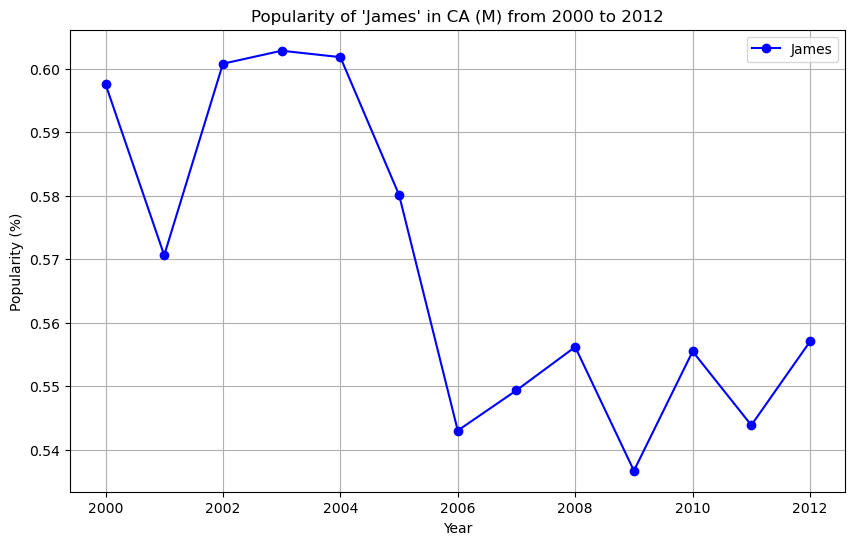

In [10]:
# pLots popularity of James over year 2000 - 2012 in CA state for male baby
data.name_popularity_plot(name = 'James', yrange=(2000,2012), state='CA', sex = 'M')

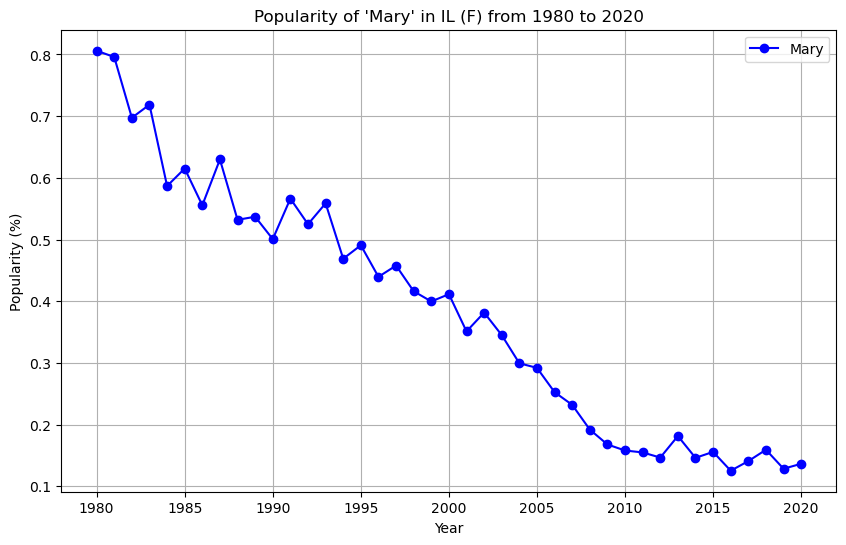

In [11]:
# pLots popularity of Mary over year 1980 - 2020 in IL state for female baby
data.name_popularity_plot(name = 'Mary', yrange=(1980,2020), state='IL', sex = 'F')

In [12]:
# returns top 10 names that popularity increase/decrease/unchange for year 2014 - 2015
data.change_in_popularity(from_year = 2014, to_year = 2015, top = 10)

Increased: ['Oliver', 'Alexa', 'Matteo', 'Mia', 'Mateo', 'Hazel', 'Charlotte', 'Grayson', 'Lincoln', 'Scarlett']
Decreased: ['Jayden', 'Isabella', 'Jase', 'Sophia', 'Andrew', 'Joshua', 'Anthony', 'Annabelle', 'Alexis', 'Peyton']
Unchanged: ['Aadit', 'Aamina', 'Aayan', 'Abdirizak', 'Abdoulaye', 'Abyan', 'Adaeze', 'Adrianne', 'Aela', 'Ainsleigh']


In [13]:
# top 5 female names for year 2013 in each state
data.top_5_names_per_year(year = 2013, sex = "F")

,State,Rank1,Num,Rank2,Num,Rank3,Num,Rank4,Num,Rank5,Num
0,AK,Emma,114,Sophia,100,Abigail,78,Isabella,76,Olivia,72
1,AL,Emma,664,Ava,520,Olivia,430,Madison,380,Isabella,362
2,AR,Emma,434,Olivia,314,Ava,288,Isabella,258,Sophia,254
3,AZ,Sophia,1226,Isabella,906,Emma,874,Mia,840,Olivia,728
4,CA,Sophia,6936,Isabella,5588,Mia,5208,Emma,4978,Emily,4592
5,CO,Olivia,636,Emma,612,Sophia,598,Isabella,470,Ava,468
6,CT,Olivia,235,Isabella,233,Emma,213,Sophia,210,Ava,190
7,DC,Charlotte,53,Sofia,48,Olivia,41,Genesis,40,Emma,37
8,DE,Ava,58,Olivia,56,Emma,51,Emily,48,Sophia,47
9,FL,Isabella,1461,Sophia,1385,Emma,1198,Olivia,1040,Mia,931


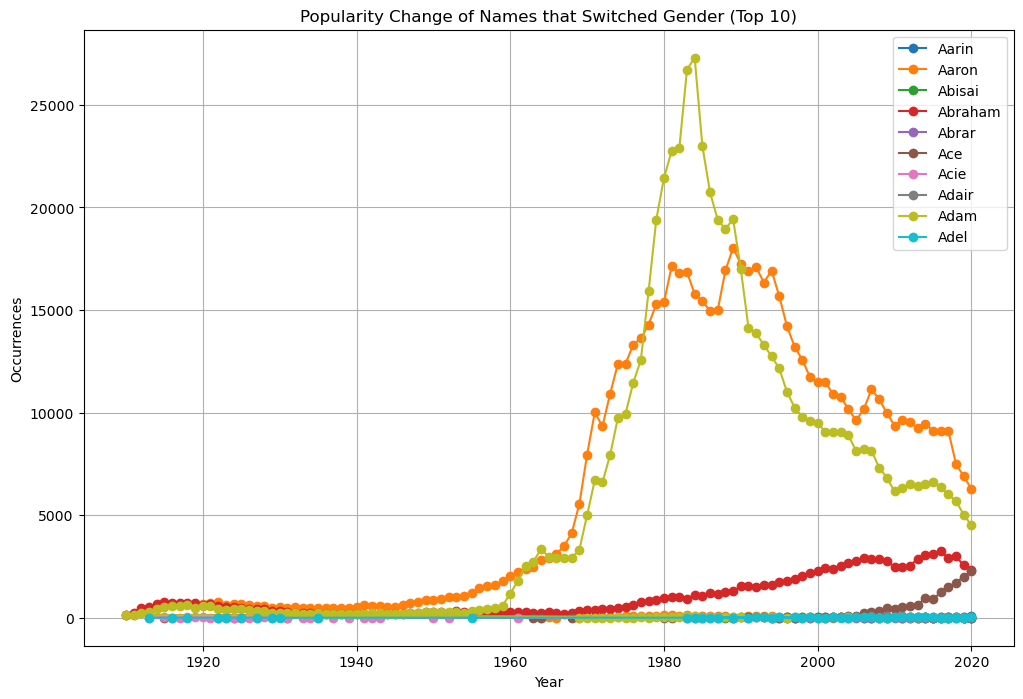

['Aarin',
 'Aaron',
 'Abisai',
 'Abraham',
 'Abrar',
 'Ace',
 'Acie',
 'Adair',
 'Adam',
 'Adel']

In [14]:
# plots popularity change of top 10 names that switched gender
data.name_flip_plot(n=10)

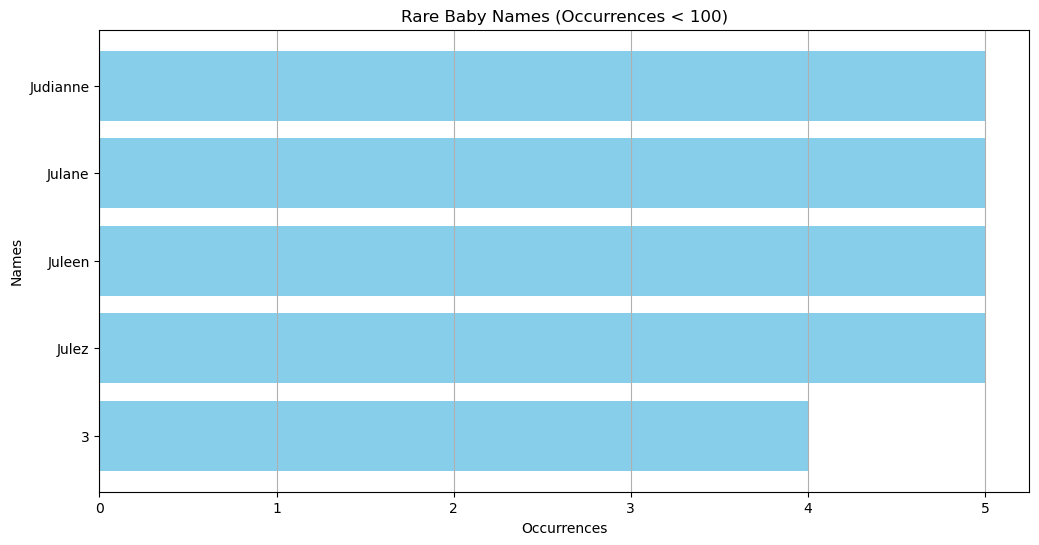

,Name,Occurrences
0,3,4
15040,Julez,5
15036,Juleen,5
15033,Julane,5
15017,Judianne,5


In [15]:
# returns top 5 rarest name where occurences < 100
data.rare_names(threshold = 100)